# Introduction

New York has around 8.4 million people (2018) and is famous for its ethnical diversity. New York City comprises 5 boroughs sitting where the Hudson River meets the Atlantic Ocean. At its core is Manhattan, a densely populated borough that’s among the world’s major commercial, financial and cultural centers. It is the largest city in the US with a long history of international immigration, as a result NYC is rich in selection of cuisines available to everyone's taste. 

I've always been a big fan of spanish tapas, and my fabourite place in London is "Paloma". The owner of "Paloma" reached out to me to do an exploratory analysis on Spanish restaurant in New York as it would be another hot spot for a tapas restaurant. 

Now, for a restaurateur who wants to open a new restaurant in this megapolis, it is important to do a thorough analysis of the market - know what types of restaurants spanish tapas menu and where are trending in the city and decide what neiborhood would be the best to open a trendy and cosy spanish tapas place. Equally, for someone who wants to experience a new spanish place - where would they go?


# Data

To be able to answer the questions raised in the introduction, we will need to look at data on New York city that contains neighborhoods, latitude, longitude, boroughs (which will help us establish boundaries), restaurants, restaurant ratings and feedback are required. This data will be retrieved from multiple data sources.
Firstly, the data on the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the following source: https://cocl.us/new_york_dataset
Secondly, venue data related to locations and quality of spanish restaurant  will be obtained via the FourSquare API utilized via the Request library in Python.



# Methodology

Data on neighborhoods, boroughs, longitudes and latitudes will be collected from https://cocl.us/new_york_dataset, then cleaned and processed into a dataframe.
FourSquare be used to locate all venues. Once we have them, we can then filter only spanish places. 

Additinal information such as ratings, feedback, and likes by users on FourSquere will be added to the dataframe. Data will be sorted based on rankings. Data will be visually assessed using graphing from Python libraries.


### Problem statement / Answers I will aim to answer

<li>
So where should we open a new spanish place in New York and why?
<li> Where would I go in New York to explore the best/new brunch place?
    
</li>


### To be able to do an exploratory analysis, let's import required libraries

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!pip install folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 93 kB 3.3 MB/s eta 0:00:011
Libraries imported.


### Provide Foursquare credentials

In [2]:
# Define Foursquare Credentials and Version


radius=1000
LIMIT=100
CLIENT_ID = 'HMIYZSHDP5FUORM0C44WIJJVPOHG32NKFHYV01OVUUTBZ0L2' # your Foursquare ID
CLIENT_SECRET = 'XKPUQCUHLT2U5OMUPWE0I3POIXBOD4QO0TTQGPKAXC534TM0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)




Your credentails:
CLIENT_ID: HMIYZSHDP5FUORM0C44WIJJVPOHG32NKFHYV01OVUUTBZ0L2
CLIENT_SECRET:XKPUQCUHLT2U5OMUPWE0I3POIXBOD4QO0TTQGPKAXC534TM0


### Define functions to be used in the project

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#Define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SJVNROHFKAQ0CZ5ULIM0V5K5IXUPI2UV1FARMVENUHS3HB4F'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='W1H0JXEDQWHBWX1ZZYT2IXCRTWLGPSNQ2NOGQ5IA4ZKCQKEU' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

import json, requests
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id='CLIENT_ID',
client_secret='CLIENT_SECRET',
v='20180323',
ll='40.7243,-74.0018',
query='coffee',
limit=1
)
resp = requests.get(url=url, params=params)
data = json.loads(resp.text)

### Define functions for venue details and neighborhoods

In [4]:
#Define a function to get venue details like like count , rating , tip counts for a given venue id. to be used for ranking.

def get_venue_details(venue_id):
        
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [5]:
# Define a function to get boroughs, neighborhoods, Latitute and Longitute

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
# get new york data
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
# Let's check how many rows we have to determine the number of boroughs:
new_york_data.shape

(306, 4)

### Number of Neighborhoods by Borough in NYC

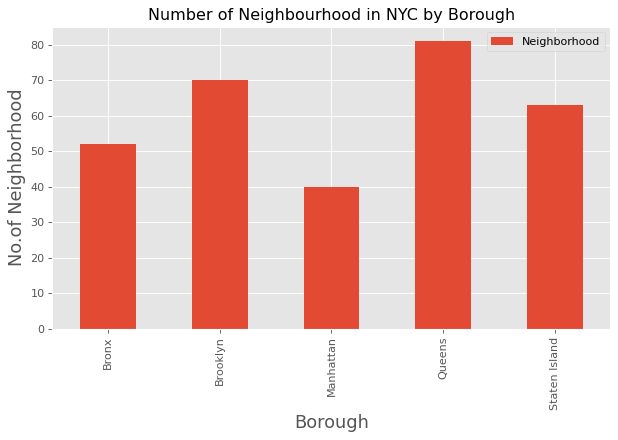

In [9]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 16)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=16)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

From the plot above, we can see that Queens Borough has the highest number of Neighborhoods, which also suggest the highest density.

In [10]:
# prepare neighborhood list that contains Spanish restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
spanish_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    spanish_resturants=venues[venues['Category']=='Spanish Restaurant']   
    print('(',count,'/',len(new_york_data),')','Spanish Resturants in '+Neighborhood+', '+Borough+':'+str(len(spanish_resturants)))
    for resturant_detail in spanish_resturants.values.tolist():
        id, name , category=resturant_detail
        spanish_rest_ny = spanish_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Spanish Resturants in Wakefield, Bronx:1
( 2 / 306 ) Spanish Resturants in Co-op City, Bronx:1
( 3 / 306 ) Spanish Resturants in Eastchester, Bronx:0
( 4 / 306 ) Spanish Resturants in Fieldston, Bronx:0
( 5 / 306 ) Spanish Resturants in Riverdale, Bronx:0
( 6 / 306 ) Spanish Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Spanish Resturants in Marble Hill, Manhattan:3
( 8 / 306 ) Spanish Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Spanish Resturants in Norwood, Bronx:2
( 10 / 306 ) Spanish Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Spanish Resturants in Baychester, Bronx:2
( 12 / 306 ) Spanish Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Spanish Resturants in City Island, Bronx:1
( 14 / 306 ) Spanish Resturants in Bedford Park, Bronx:2
( 15 / 306 ) Spanish Resturants in University Heights, Bronx:3
( 16 / 306 ) Spanish Resturants in Morris Heights, Bronx:2
( 17 / 306 ) Spanish Resturants in Fordham, Bronx:5
( 18 / 306 ) Spanish Resturants in East Tremont, Bronx:

In [11]:
spanish_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4bec3ac661aca5935cfe8500,El Mangu Tipico Restaurant
1,Bronx,Co-op City,58a9ca678ae363643f8827a2,Sangria Cafe
2,Bronx,Kingsbridge,4ca785a597c8a1cd7e577ba5,El Economico Restaurant
3,Bronx,Kingsbridge,50ea5611e4b044bdeead3ade,Q'Kachapa
4,Manhattan,Marble Hill,4ca785a597c8a1cd7e577ba5,El Economico Restaurant


In [12]:
spanish_rest_ny.shape

(112, 4)

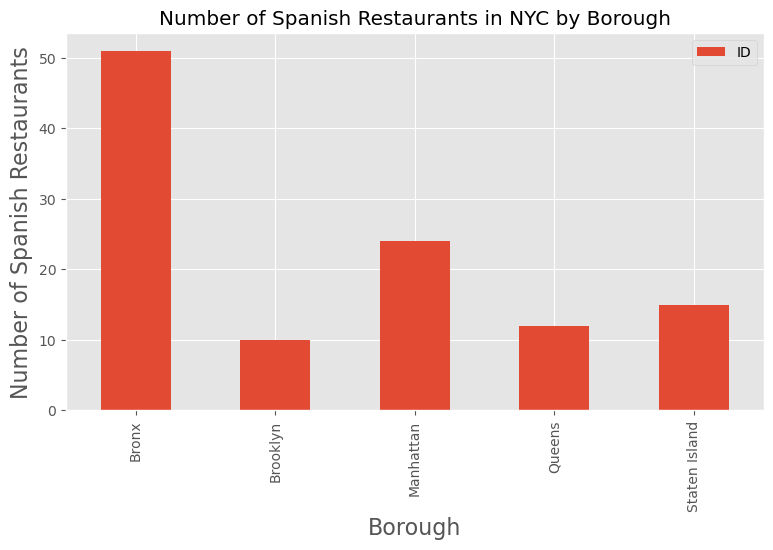

In [13]:
# Let's check how these 112 restaurants distribute across different boroughs:

from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Spanish Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 16)
#On y-axis
plt.ylabel('Number of Spanish Restaurants', fontsize=16)
#giving a bar plot
spanish_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We can clearly see that the highest number of spanish restaurants are in Bronx, although Queens has the highest number of neighborhoods. It's interesting to see what is the distribution of restaurants across different Neighborhoods in New York.

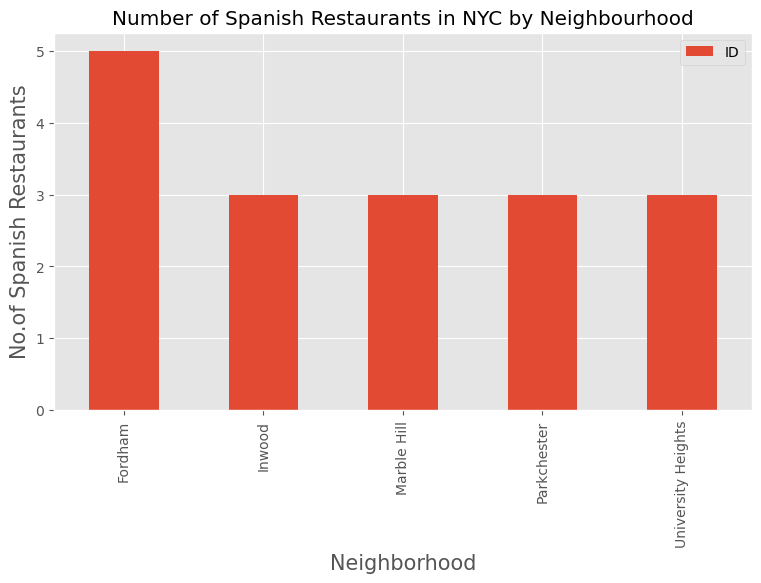

In [14]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Spanish Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Spanish Restaurants', fontsize=15)
#giving a bar plot
spanish_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We can see that Fordham alone has 5 spanish restaurants, which makes is the highest number of spanish restaurants of all neighborhoods in NYC. Fordham is in Bronx Borough which is consistent with the highest density of spanish restaurants across different Boroughs.

### Now that we have a picture of NYC boroughs, neighborhoods and spanish restaurants in the city we can look into venue details from Foursquare

In [15]:
# prepare neighborhood list that contains spanish resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
spanish_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in spanish_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains spanish resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
spanish_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in spanish_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(spanish_rest_ny),')','processed')
    spanish_rest_stats_ny = spanish_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bec3ac661aca5935cfe8500
( 1 / 112 ) processed
                         ID          Name  Likes  Rating  Tips
0  58a9ca678ae363643f8827a2  Sangria Cafe      7     7.7     3
( 2 / 112 ) processed
                         ID                     Name  Likes  Rating  Tips
0  4ca785a597c8a1cd7e577ba5  El Economico Restaurant     18     7.6     8
( 3 / 112 ) processed
                         ID       Name  Likes  Rating  Tips
0  50ea5611e4b044bdeead3ade  Q'Kachapa     16     7.3     6
( 4 / 112 ) processed
                         ID                     Name  Likes  Rating  Tips
0  4ca785a597c8a1cd7e577ba5  El Economico Restaurant     18     7.6     8
( 5 / 112 ) processed
                         ID       Name  Likes  Rating  Tips
0  50ea5611e4b044bdeead3ade  Q'Kachapa     16     7.3     6
( 6 / 112 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for

### Let's have a quick look at the table

In [16]:
spanish_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0,0,0
1,Bronx,Co-op City,58a9ca678ae363643f8827a2,Sangria Cafe,7,7.7,3
2,Bronx,Kingsbridge,4ca785a597c8a1cd7e577ba5,El Economico Restaurant,18,7.6,8
3,Bronx,Kingsbridge,50ea5611e4b044bdeead3ade,Q'Kachapa,16,7.3,6
4,Manhattan,Marble Hill,4ca785a597c8a1cd7e577ba5,El Economico Restaurant,18,7.6,8


It seems that there is not data available to get the likes, ratings and tips.

In [17]:
spanish_rest_stats_ny.shape


(112, 7)

In [18]:
spanish_rest_ny.shape

(112, 4)

### I'll save the data on the restaurant stats to the csv file

In [19]:
spanish_rest_stats_ny.to_csv('spanish_rest_stats_ny.csv', index=False)

In [20]:
spanish_rest_stats_ny_csv=pd.read_csv('spanish_rest_stats_ny.csv')


In [21]:
spanish_rest_stats_ny_csv.shape


(112, 7)

In [22]:
spanish_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0,0.0,0
1,Bronx,Co-op City,58a9ca678ae363643f8827a2,Sangria Cafe,7,7.7,3
2,Bronx,Kingsbridge,4ca785a597c8a1cd7e577ba5,El Economico Restaurant,18,7.6,8
3,Bronx,Kingsbridge,50ea5611e4b044bdeead3ade,Q'Kachapa,16,7.3,6
4,Manhattan,Marble Hill,4ca785a597c8a1cd7e577ba5,El Economico Restaurant,18,7.6,8


### Let's check the data types in our Rating table and change them if needed:

In [23]:
spanish_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       112 non-null    object
 1   Neighborhood  112 non-null    object
 2   ID            112 non-null    object
 3   Name          112 non-null    object
 4   Likes         112 non-null    object
 5   Rating        112 non-null    object
 6   Tips          112 non-null    object
dtypes: object(7)
memory usage: 6.2+ KB


In [24]:
spanish_rest_stats_ny['Likes']=spanish_rest_stats_ny['Likes'].astype('float64')

In [25]:
spanish_rest_stats_ny['Tips']=spanish_rest_stats_ny['Tips'].astype('float64')

In [32]:
spanish_rest_stats_ny['Rating']=spanish_rest_stats_ny['Rating'].astype('float64')

### Now that we corrected the data types, let's continue with the analysis

In [33]:
spanish_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       112 non-null    object 
 1   Neighborhood  112 non-null    object 
 2   ID            112 non-null    object 
 3   Name          112 non-null    object 
 4   Likes         112 non-null    float64
 5   Rating        112 non-null    float64
 6   Tips          112 non-null    float64
dtypes: float64(3), object(4)
memory usage: 6.2+ KB


In [30]:
spanish_rest_stats_ny.describe()

,Likes,Tips
count,112.000000,112.000000
mean,5.964286,3.062500
std,13.067344,5.921835
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,7.000000,6.000000
max,66.000000,33.000000


From the table above we have see that there are more thant half of entries with missing data for likes and tips, so we will do the analysis on the data we have

### Identify and visualize neighborhood with the maximum average rating of restaurants


In [28]:
# Show restaurants with maximum Likes
spanish_rest_stats_ny.iloc[spanish_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                  Baychester
ID              4be2ecf6b02ec9b6a5064ec0
Name                     Caridad & Louie
Likes                                 66
Rating                                 8
Tips                                  27
Name: 9, dtype: object

In [34]:
# Show restaurants with maximum Rating
spanish_rest_stats_ny.iloc[spanish_rest_stats_ny['Rating'].idxmax()]

Borough                             Bronx
Neighborhood                  Parkchester
ID               4eed3d759a52993fb7108490
Name            Isla Verde Cafe & Express
Likes                                  48
Rating                                8.2
Tips                                   14
Name: 32, dtype: object

In [35]:
# Show restaurants with maximum Tips
spanish_rest_stats_ny.iloc[spanish_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                    Van Nest
ID              4b8db810f964a5206a0a33e3
Name                       Cafe Colonial
Likes                                 42
Rating                               7.3
Tips                                  33
Name: 35, dtype: object

This way we identified 3 leading restaurants by Likes, Ratings and Tips 

### Restaurants with the higest Ratings by Neighborhood

In [36]:
ny_neighborhood_stats=spanish_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [37]:
#Let's check the top 10 neighborhoods that have the highest average rating for spanish restaurants
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Neighborhood,Average Rating
1,Baychester,7.850000
14,Co-op City,7.700000
59,Parkchester,7.666667
51,Mott Haven,7.600000
38,Kingsbridge,7.450000
67,Sunset Park,7.250000
7,Brownsville,7.100000
27,Fordham,7.060000
4,Belmont,7.000000
48,Morris Heights,6.900000


In [38]:
#Let's do the same with boroughs:

ny_borough_stats=spanish_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [39]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,4.919608
1,Brooklyn,2.160000
2,Manhattan,0.620833
3,Queens,0.000000
4,Staten Island,0.000000


### Let's visualize these results of top rated spanish restaurants

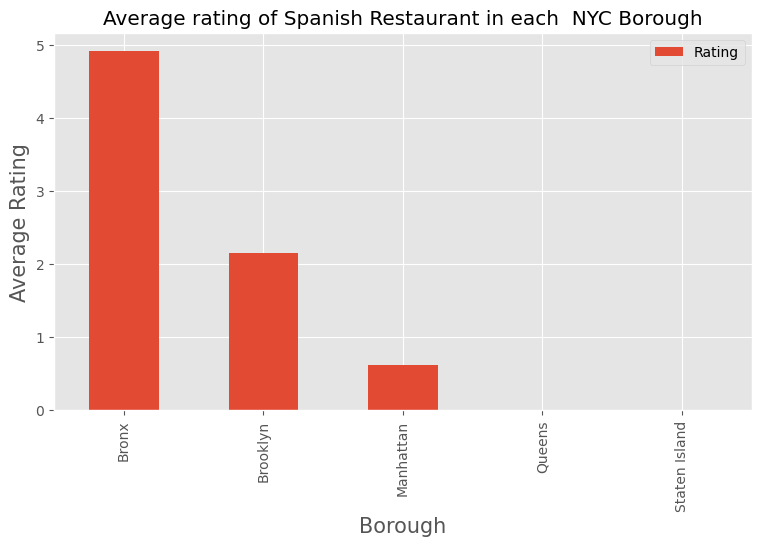

In [40]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Spanish Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
spanish_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

What borough has the highest average rating for a spanish restaurant in Bronx. It is not surprising given that Bronx has the most Spanish restaurants. We can now conclude that not only Bronx has the most spanish restaurants, it also has the highest rated restaurants.

## Limitations and recommendations

The biggest limitation was that the data was not available on venues ratings in the city. We determined where/how spanish restaurants are distrubuted in NYC but we can only conclude on the best restaurants with the data we have.

Bronx has the highest number of the spanish restaurants and these restaurants have the highest ratings on average so it might be difficult to compete.
<li>I would recommend to open a new restaurant in Queens and/or Brooklyn because it has more neighborhoods and much fewer spanish restaurants. 
    <li>Possibility for less competition and a bigger crowd.
        </li>